## `Course evaluation information`

- Concisely note down your observations for each lab from now on.
- You can take notes inside the notebooks, or in separate PDFs.
- Either way, be ready to show the work you putted into each lab, including the experiments and the learning outcomes.
- During the exam, you will be asked to show your notes for some of the labs at random with a brief discussion on its content

# Lab. 1: Local search

## Introduction

#### <u>The goal is to study the application of local search algorithms on different benchmark functions.</u>

We will see the following methods:
- *Grid Search*
- *Random Search*
- *Powell*
- *Nelder Mead*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or you can print it with *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [1]:
%%capture

try:
  import benchmark_functions as bf
except:
  !pip3 install benchmark_functions
  import benchmark_functions as bf

from scipy.optimize import minimize, rosen
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

plt.rcParams["figure.figsize"] = (8,5)


In [2]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        
        return self.f.minima()

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.xlabel('Iterations')
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

def grid_search(f: OptFun, step_size=None, number_of_steps=None):
    """
    Optimizes a function by using the grid_search algorithm.

    - f: function to optimize, an instance of OptFun
    - step_size: the step size
    - number_of_steps: the total number of steps
    """
    bounds = f.bounds()
    if (step_size != None):
        for x in np.arange(bounds[0][0], bounds[0][1], step_size):
            for y in np.arange(bounds[1][0], bounds[1][1], step_size):
                func([x, y])
    elif (number_of_steps != None):
        for x in np.linspace(bounds[0][0], bounds[0][1], int(np.floor(np.sqrt(number_of_steps)))):
            for y in np.linspace(bounds[1][0], bounds[1][1], int(np.floor(np.sqrt(number_of_steps)))):
                func([x, y])
    else:
        print("Please provide at least the step_size or the")

def random_search(f: OptFun, n_samples_drawn):
    """
    Optimizes a function by using the random_search algorithm.

    - f: function to optimize, an instance of OptFun
    - number_of_steps: the total number of steps
    """
    bounds = f.bounds()
    for i in range(n_samples_drawn):
        x = np.random.uniform(bounds[0][0], bounds[0][1])
        y = np.random.uniform(bounds[1][0], bounds[1][1])
        func([x, y])

def powell(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Powell algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    results = minimize(fun=f, x0=list(x0), method="powell", bounds=bounds,
                       options={"ftol":1e-4,
                                "maxfev": None,
                                "maxiter": maxiter,
                                "return_all":True})
    return results

def nelder_mead(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Nelder-Mead algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    return minimize(
        f,
        x0,
        method='Nelder-Mead',
        tol=None,
        bounds=bounds,
        options={
            "maxfev": None,
            "maxiter": maxiter,
            'disp': False,
            'return_all': True,
            'initial_simplex': None,
            'xatol': 0.000,
            'fatol': 0.000,
            'adaptive': False
        }
    )

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?

The most complex and multimodal functions are particularly difficult to optimize because they have multiple local minima, making the search for the global minimum a challenging task.

Furthermore, the choice of the optimal algorithm also depends on the nature of the benchmark function. For example, random search might prove more effective than grid search for multimodal functions, as it explores random points and thus has a higher chance of avoiding local minima. On the other hand, grid search, being deterministic, might tend to get trapped in local minima, especially depending on the starting point.

- The choiche of the parameters is influenced by the function to optimize? And how the algorithms are influenced by the parameters?

Yes, the choice of parameters can be influenced by the function to optimize. For more complex functions, it might be advantageous to increase the number of steps or the number of sampled points to ensure a more accurate coverage of the search space. However, it's important to consider that increasing these parameters can lead to an increase in computational costs.

## Exercise 1/4: GRID SEARCH
In this first exercise we will use grid search as a search algorithm

### Questions
- How does the step size influence the quality of the best point obtained?

Grid search operates by discretizing the exploration space, and a smaller step size allows for the definition of a more detailed grid. Consequently, a smaller step size provides greater precision in exploring the parameter space, enabling the algorithm to find the optimal value more accurately. 

- How does the step size influence the search cost?

Having a more detailed grid implies that more steps are needed to explore the entire parameter space. As a result, the search cost will be higher because the algorithm needs to evaluate more combinations of parameters. 


optimal value =  0.0

ITER N 0:
step_size = 0.1
minimum value = 6.310887241768094e-28


<Figure size 800x500 with 0 Axes>

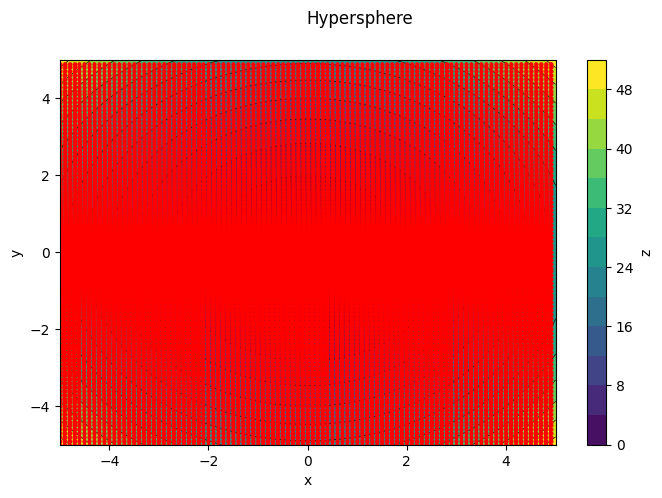

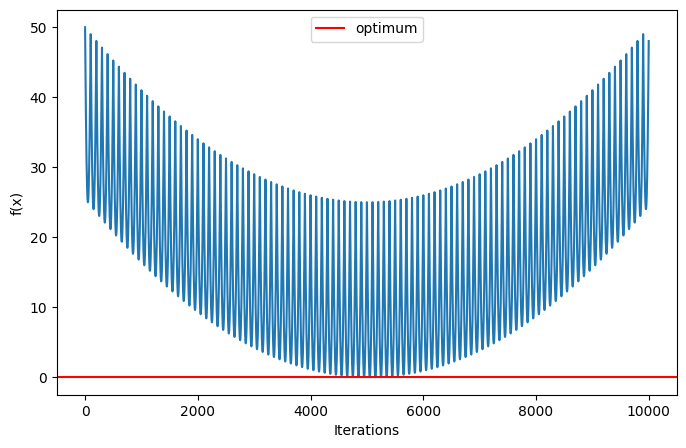


ITER N 1:
step_size = 1
minimum value = 0.0


<Figure size 800x500 with 0 Axes>

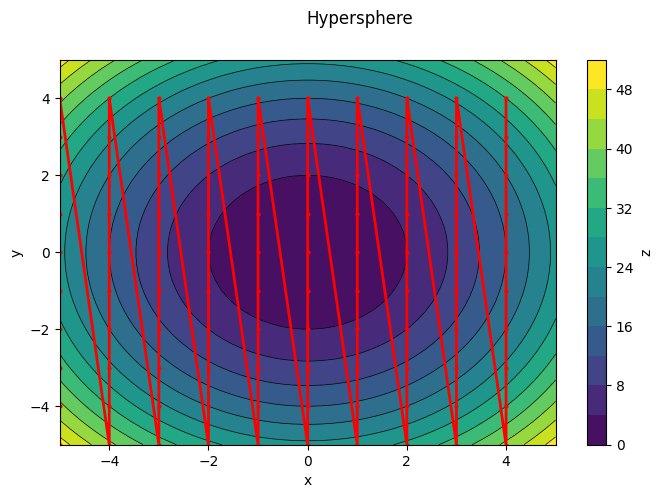

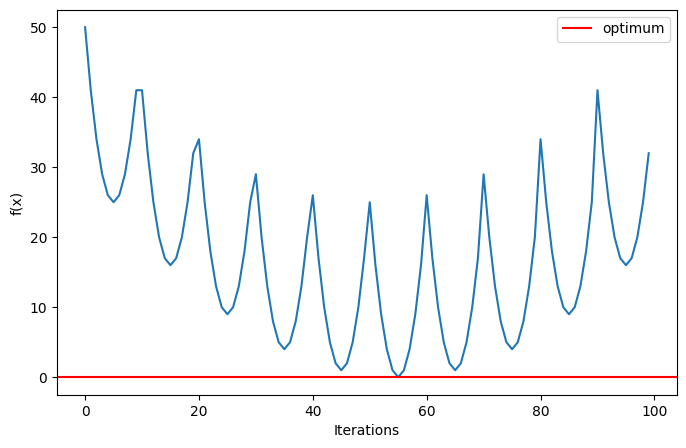


ITER N 2:
step_size = 3
minimum value = 2.0


<Figure size 800x500 with 0 Axes>

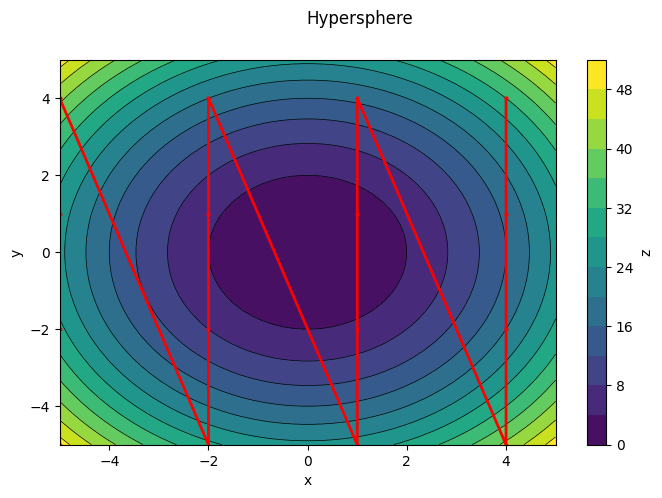

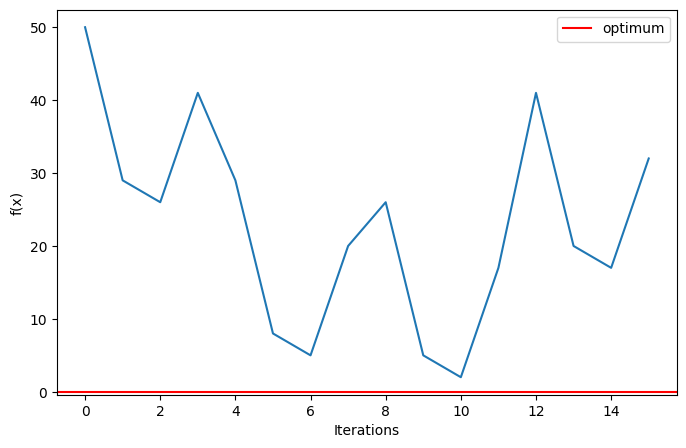


ITER N 3:
step_size = 6
minimum value = 2.0


<Figure size 800x500 with 0 Axes>

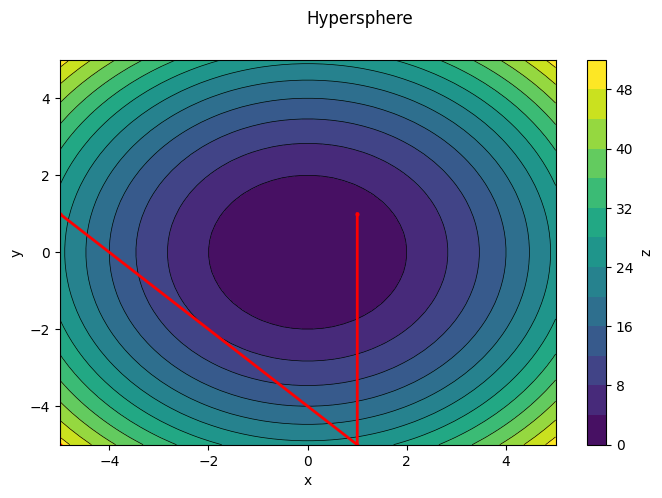

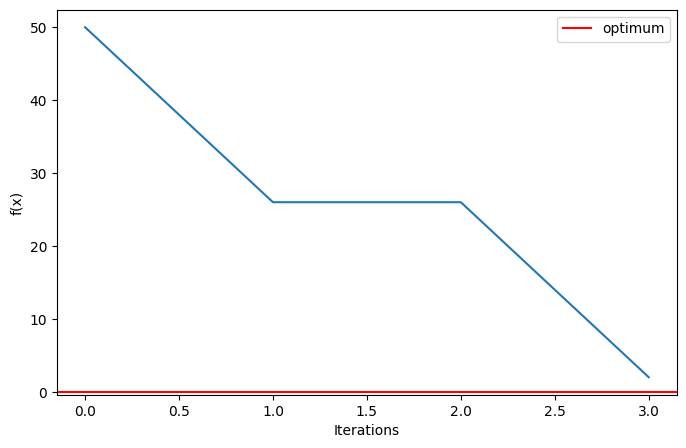


ITER N 4:
step_size = 9
minimum value = 32.0


<Figure size 800x500 with 0 Axes>

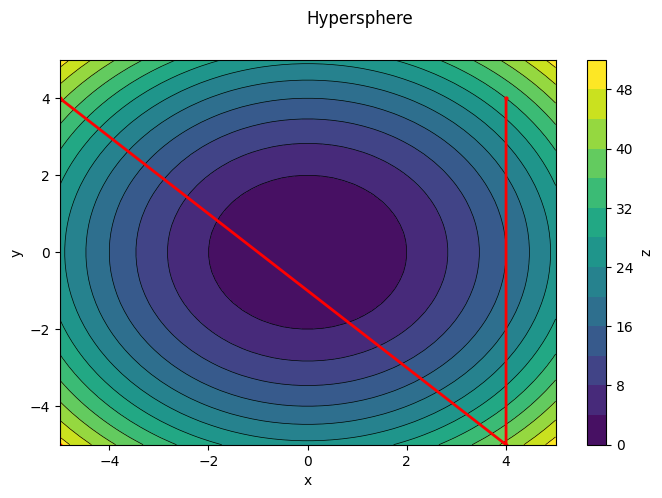

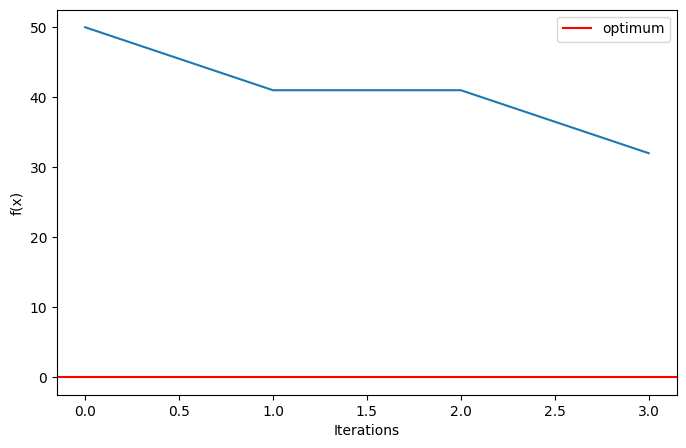

In [3]:
hypersphere = bf.Hypersphere(2)  # TODO: try differenct benchmark functions
func = OptFun(hypersphere)
step_size_list = [0.1, 1, 3, 6, 9]   # TODO: try different step_size values (e.g.: [0.5, 1, 3])

print('\noptimal value = ', func.minima()[0].score )

for i, step_size in enumerate(step_size_list):
    func = OptFun(hypersphere)
    print(f'\nITER N {i}:\nstep_size =', step_size)
    grid_search(func, step_size=step_size)
    values = [func.f(v) for v in func.history]
    print('minimum value =', min(values))
    func.heatmap()
    func.plot()
    

## Exercise 2/4: RANDOM SEARCH

In this exercise we will use Random Search to search for the optimum

### Questions
- How does the number of samples drawn affect the search?

Increasing the number of samples provides a broader range of choices for finding the optimal value. However, this also results in higher computational costs due to the increased number of evaluations required. 

- How does this method compare to Grid Search? What are the advantages and disadvantages?

The key distinction between grid search and random search lies in their approach to parameter exploration, the grid search is a deterministich approach while random search is a stochastic one. Grid search partitions the exploration space into a predefined grid and evaluates only specific points within this grid, whereas random search selects points randomly across the entire space without any discretization. Consequently, grid search suffers from information loss due to discretization, but ensures the evaluation of every point within the grid and finds the optimal one. On the other hand, random search may overlook optimal points entirely, making it less guaranteed to find the optimal solution. While grid search tends to be more computationally expensive due to the exhaustive evaluation of predefined points, random search offers variability in results; for a fixed number of samples, the outcome of random search may vary across different runs, unlike grid search where the result remains consistent given the same grid and step size.



optimal value =  0.0

ITER N 0:
_samples_drawn = 2
minimum value = 8.623321825137154


<Figure size 800x500 with 0 Axes>

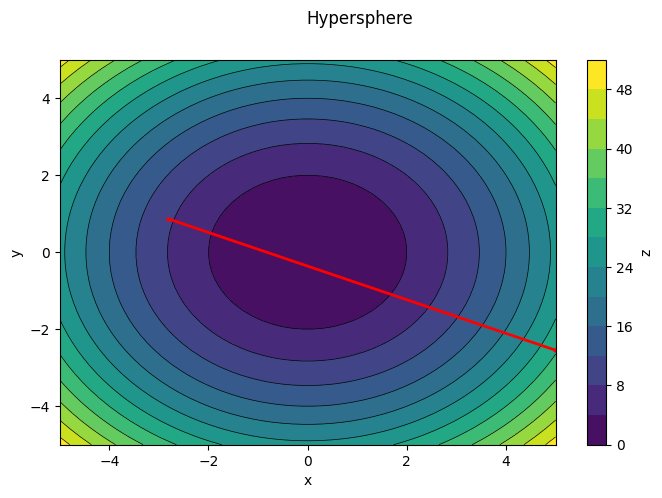

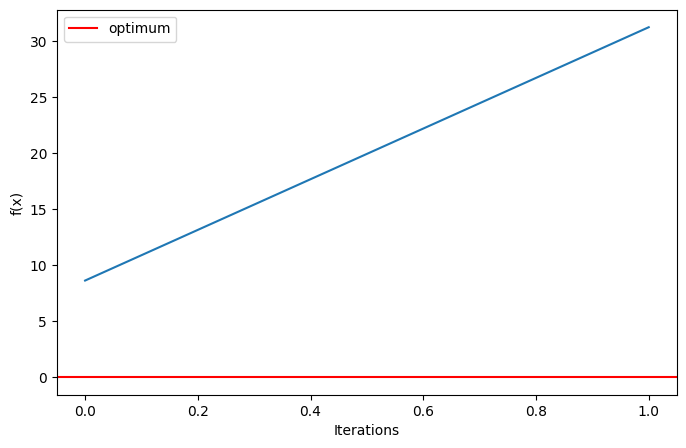


ITER N 1:
_samples_drawn = 5
minimum value = 2.369893903138233


<Figure size 800x500 with 0 Axes>

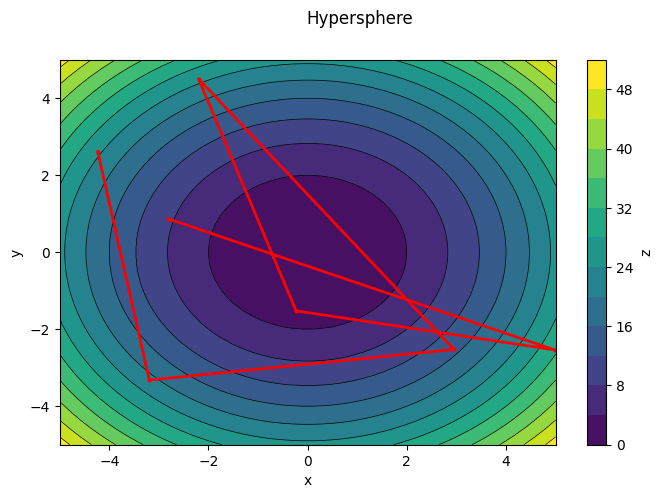

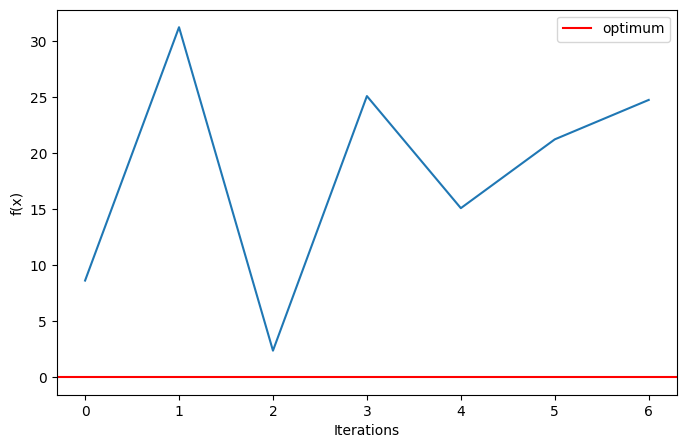


ITER N 2:
_samples_drawn = 10
minimum value = 1.1353223835504083


<Figure size 800x500 with 0 Axes>

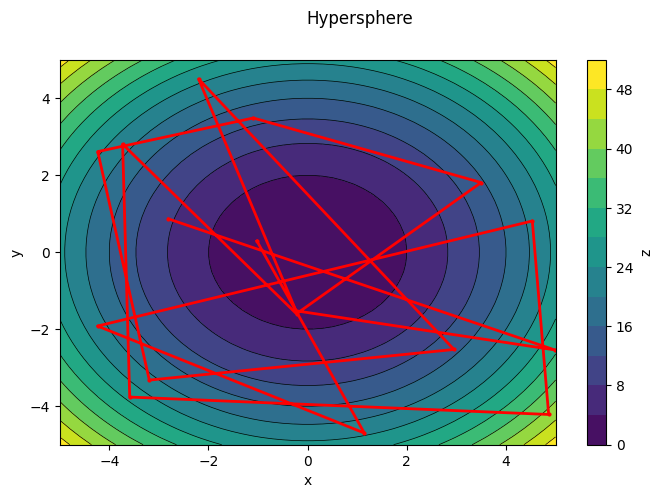

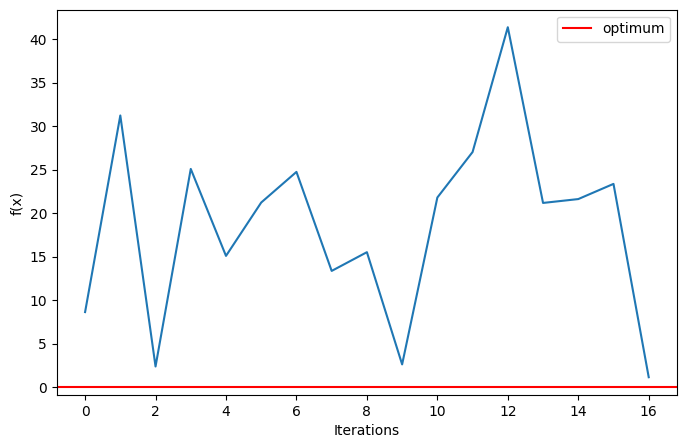


ITER N 3:
_samples_drawn = 100
minimum value = 0.06334366767863184


<Figure size 800x500 with 0 Axes>

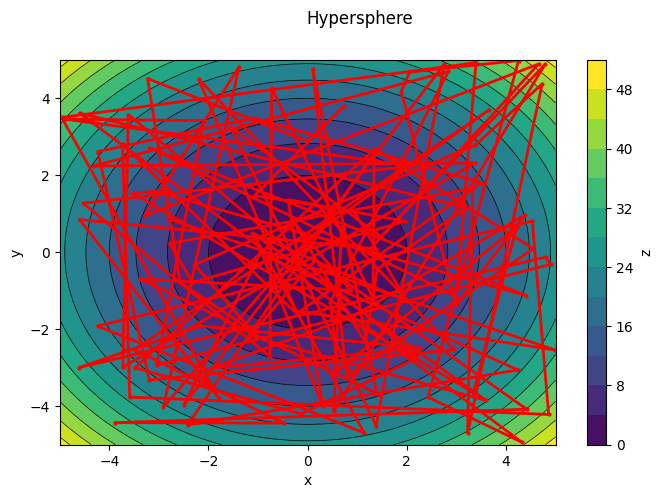

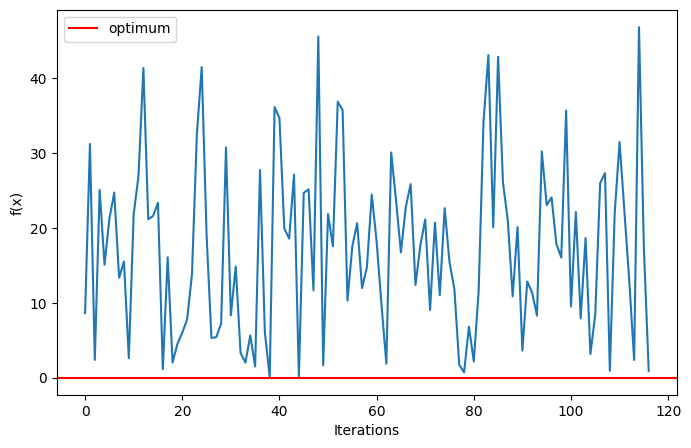

<Figure size 800x500 with 0 Axes>

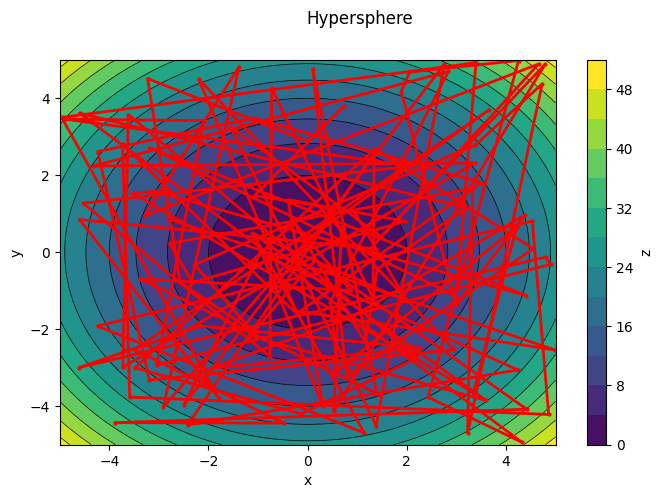

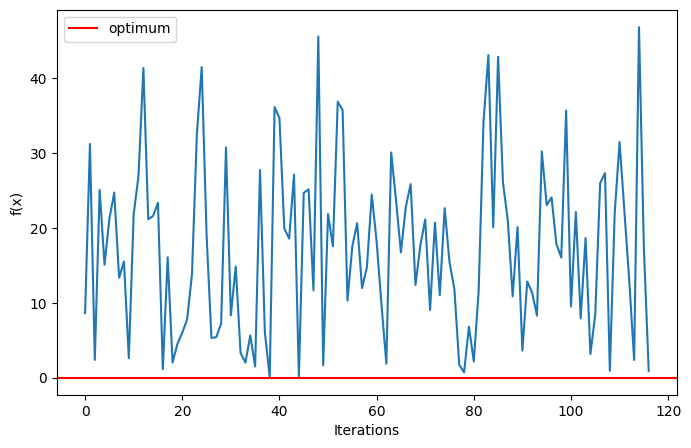

In [4]:
func = OptFun(bf.Hypersphere(2))  # TODO: try differenct benchmark functions
bounds = func.bounds()
n_samples_drawn_list = [2, 5, 10, 100]  # TODO: try different values (e.g.: [3, 30, 50])

print('\noptimal value = ', func.minima()[0].score )

for i, n_samples_drawn in enumerate(n_samples_drawn_list):
    random_search(func, n_samples_drawn)
    print(f'\nITER N {i}:\n_samples_drawn =', n_samples_drawn)
    values = [func.f(v) for v in func.history]
    print('minimum value =', min(values))
    func.heatmap()
    func.plot()

func.heatmap()
func.plot()

In [32]:
# TODO: compare to Grid Search

## Exercise 3/4: POWELL OPTIMIZATION

In this exercise we will focus on the Powel optimization algorithm.

### Questions
- What happens when varying the parameters of the algorithm? 

Different starting points influence convergence, particularly in complex functions. A good initial point can expedite convergence towards the global optimum, especially with fewer iterations. However, the impact of the initial point diminishes as iterations progress.
Adjusting max_iter determines the algorithm's runtime. Increasing it allows for more exploration but risks unnecessary computational costs if set excessively high. Moreover, as the number of iterations increases, a more accurate value is obtained.

- How they influence the optimization process? 

A well-chosen initial point can significantly accelerate convergence, especially in complex functions with numerous local optima. This is particularly in the Powell's method, as it iteratively chooses directions to minimize. The starting point strongly influences the final result, as the method has a tendency to produce sets of directions that become linearly dependent. Hence, different initial points lead to different sets of directions. On the other hand, the maximum number of iterations directly influences the duration of the search. Increasing the number of iterations allows for more exploration of the parameter space, potentially improving convergence towards the optimal solution. However, setting the number of iterations too high can result in unnecessary computational expenses if the algorithm converges well before reaching the maximum limit. Therefore, is need a balance between too few iterations, which may prematurely terminate the optimization, and too many iterations, which may be overly expensive.

- The effects of these parameters is the same across different functions? 

A good starting point is particularly valuable, especially in complex functions with numerous local optima.  Additionally, in such functions, a higher number of iterations proves to be more helpful

- How does this algorithm compare to the previous?

The Powell's optimization algorithm converges quadratically to the optimal solution, making it highly efficient in finding the best parameters. However, this efficiency comes at the cost of increased computational time, as Powell's method requires more expensive computations. On the other hand, random search, while simpler to implement, does not guarantee convergence to the optimal parameters. It may require a larger number of function evaluations compared to Powell's algorithm, especially in high-dimensional spaces or functions with many local optima. Random search is less sensitive to the characteristics of the optimization function and can handle a wider range of functions, making it more robust and versatile. In general, for smooth functions, Powell's method tends to perform better, whereas random search shines in handling complex functions despite potentially requiring more evaluations to converge.


In [5]:
# list of functions
print(dir(bf))


['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']



punto iniziale =  [-1.684631438937065, 1.2762646987189994]
optimal value =  -3.129125550610585

ITER N 0:
max_iter =  1

minimum value = 0.821335963060752


<Figure size 800x500 with 0 Axes>

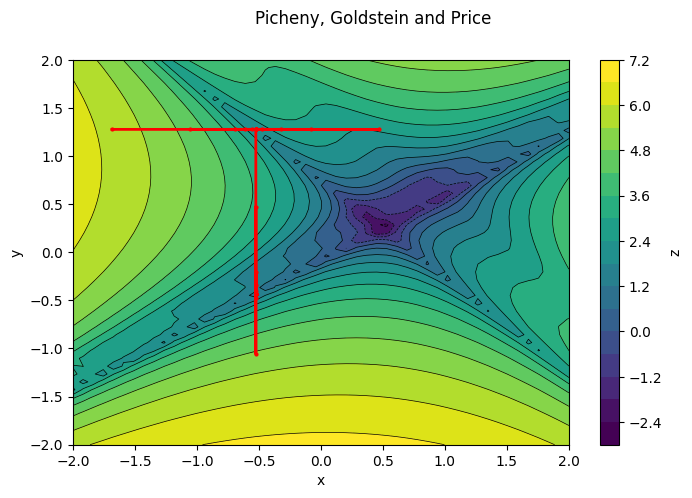

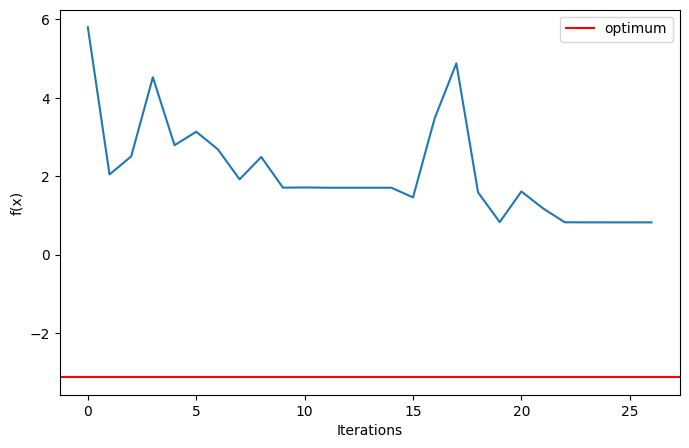


ITER N 1:
max_iter =  2

minimum value = 0.8185145695155632


<Figure size 800x500 with 0 Axes>

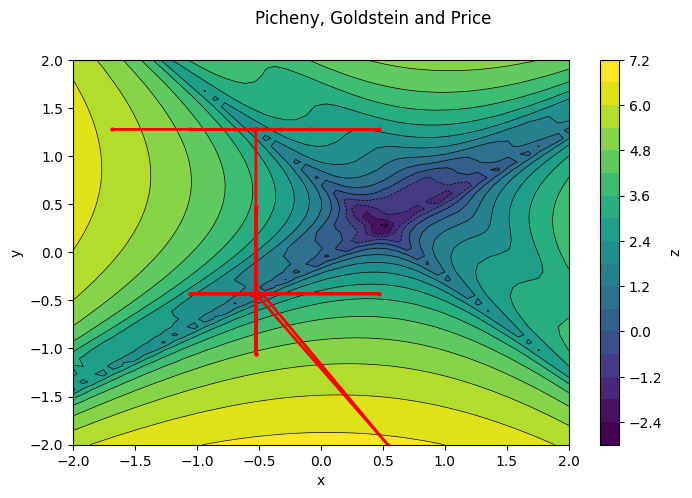

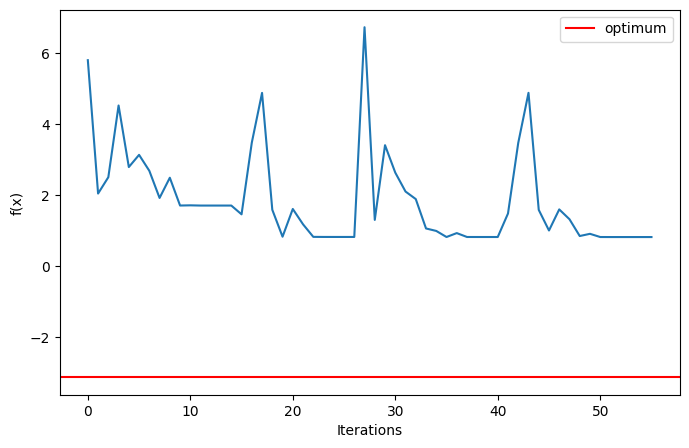


ITER N 2:
max_iter =  5

minimum value = -3.1291255482905598


<Figure size 800x500 with 0 Axes>

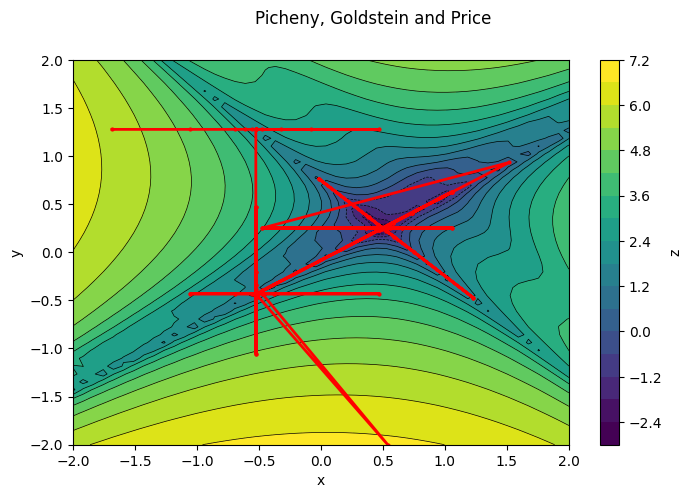

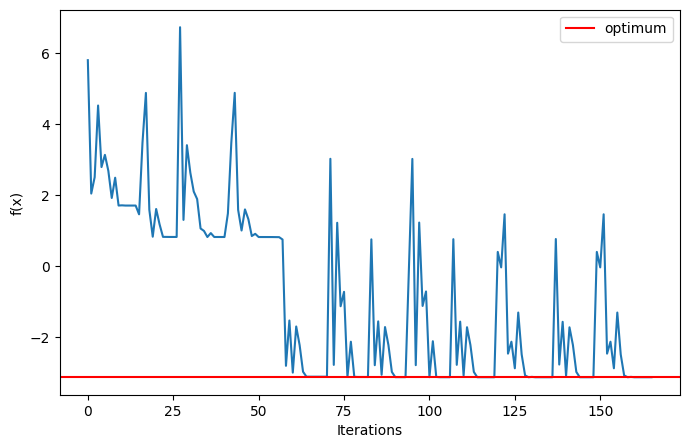


ITER N 3:
max_iter =  100

minimum value = -3.1291255482905598


<Figure size 800x500 with 0 Axes>

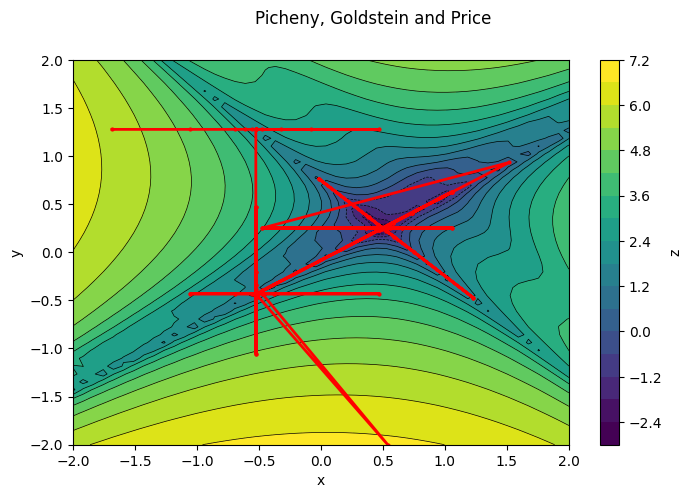

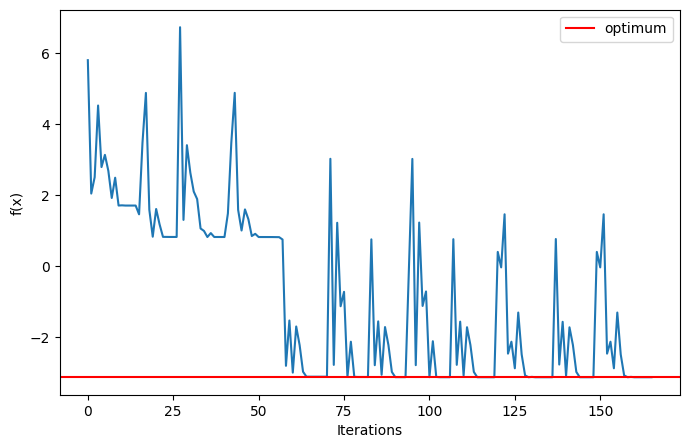


ITER N 4:
max_iter =  10000

minimum value = -3.1291255482905598


<Figure size 800x500 with 0 Axes>

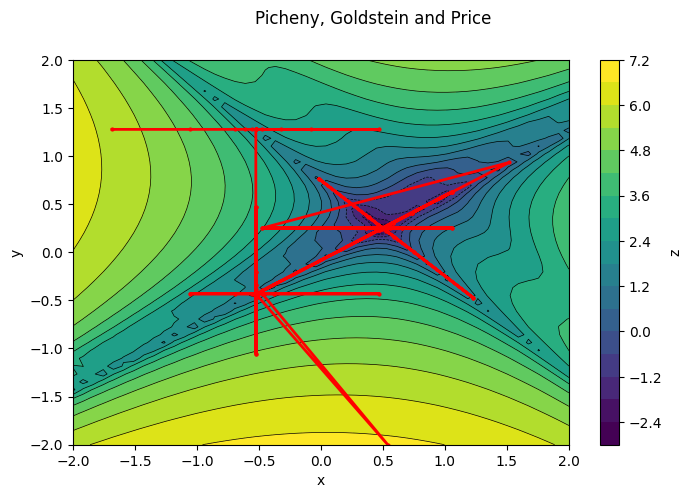

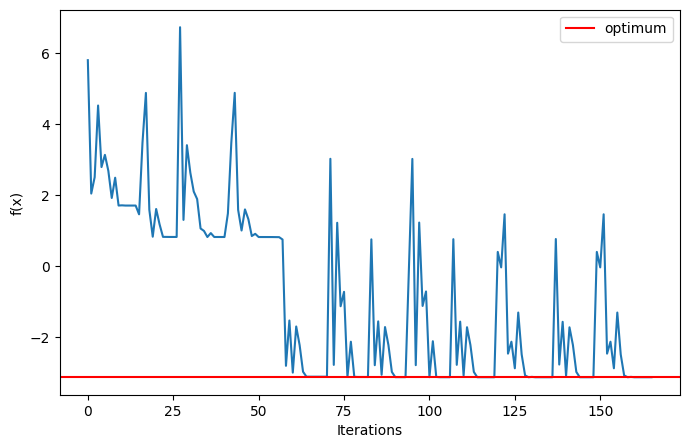

[(0.0, 3.141592653589793), (0.0, 3.141592653589793)]

punto iniziale =  [2.5173292414342017, 1.4727022420589566]
optimal value =  -1.8013034100904854

ITER N 0:
max_iter =  1

minimum value = -1.8013034041759115


<Figure size 800x500 with 0 Axes>

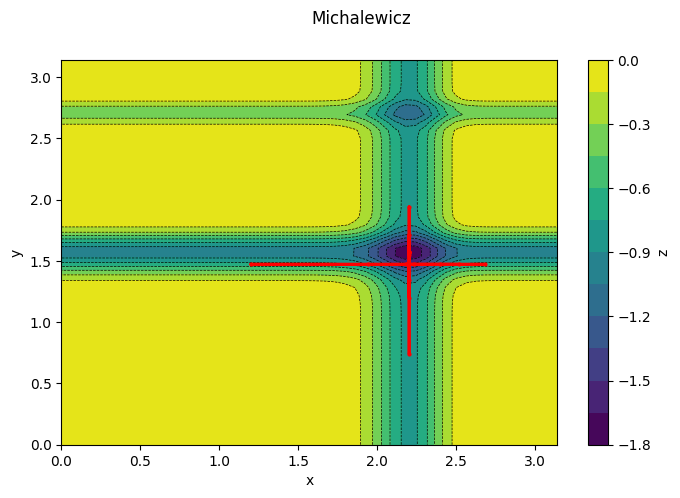

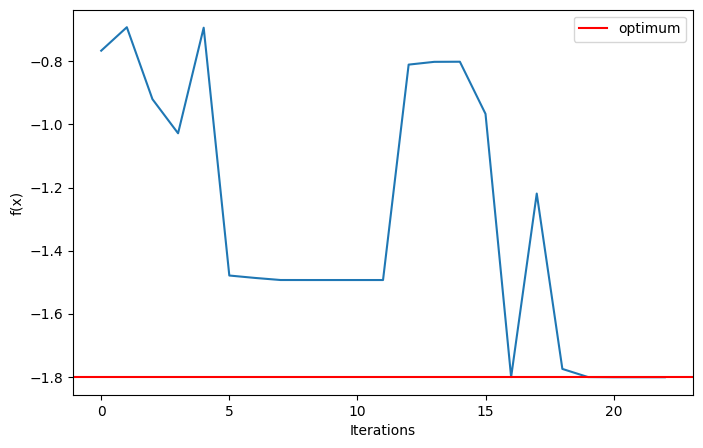


ITER N 1:
max_iter =  2

minimum value = -1.801303404175912


<Figure size 800x500 with 0 Axes>

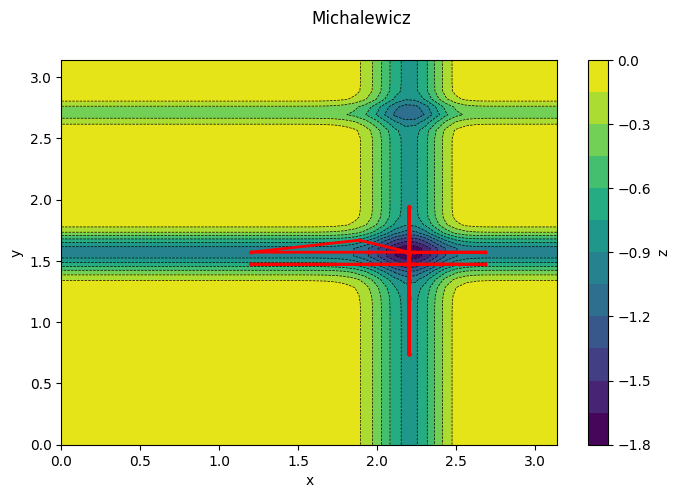

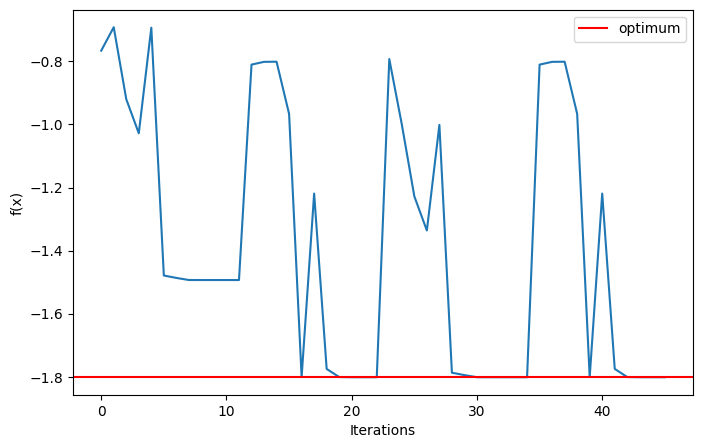


ITER N 2:
max_iter =  5

minimum value = -1.801303404175912


<Figure size 800x500 with 0 Axes>

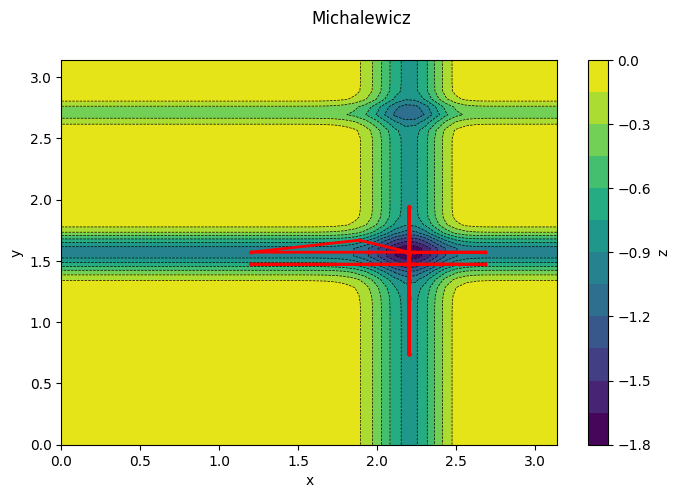

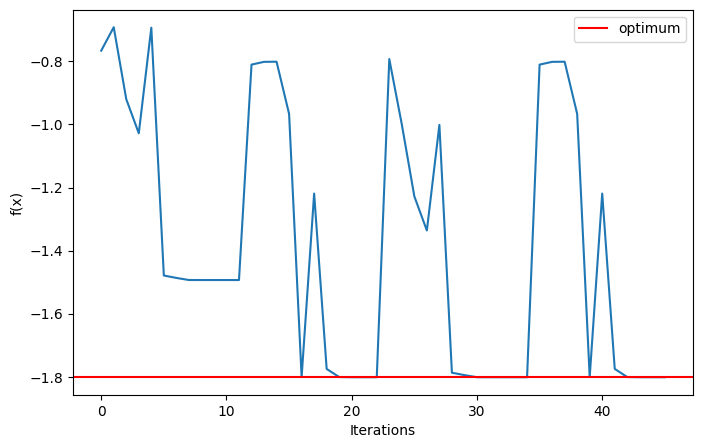


ITER N 3:
max_iter =  100

minimum value = -1.801303404175912


<Figure size 800x500 with 0 Axes>

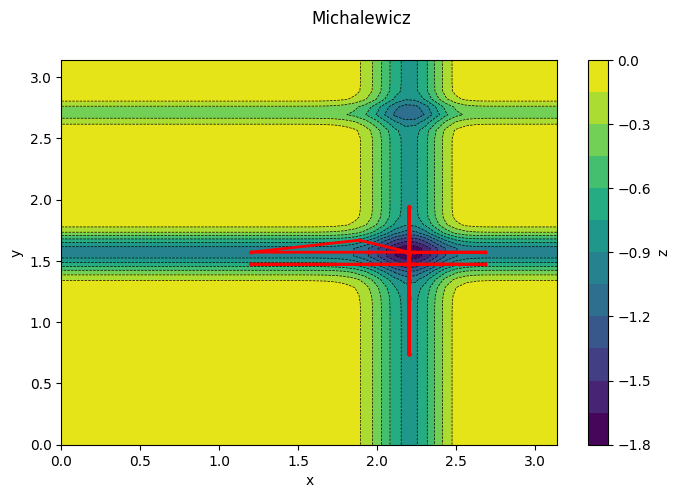

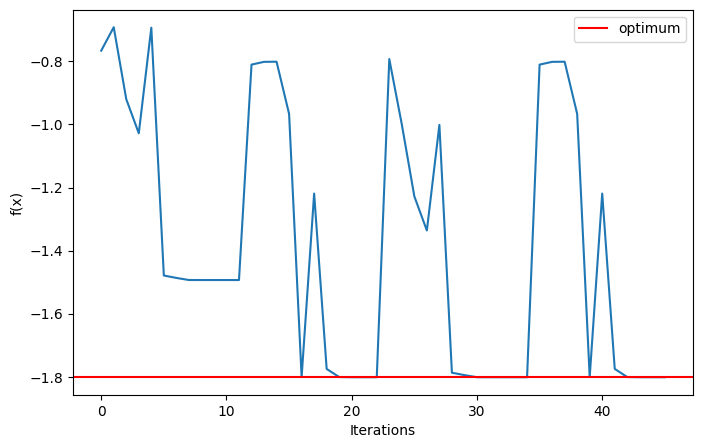


ITER N 4:
max_iter =  10000

minimum value = -1.801303404175912


<Figure size 800x500 with 0 Axes>

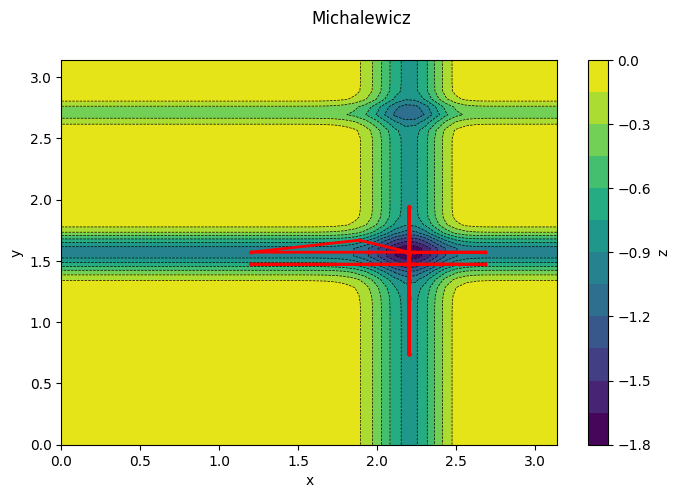

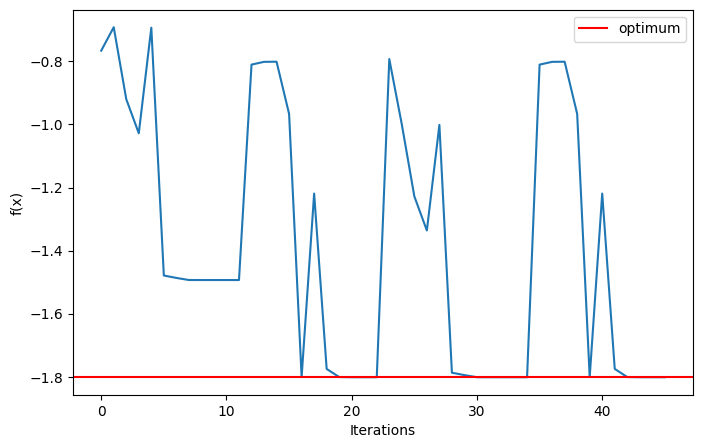

In [29]:
import random
func = OptFun(bf.PichenyGoldsteinAndPrice())    # TODO: try differenct benchmark functions and parameters
x_0 = [random.uniform(func.bounds()[0][0], func.bounds()[0][1]) for _ in range(2)]  # TODO: try other suitable initial points



print('\npunto iniziale = ',x_0)
print('optimal value = ', func.minima()[0].score )

max_iter_list = [1, 2, 5, 100, 10000]  # TODO: try other values
for i, max_iter in enumerate(max_iter_list):
    func = OptFun(bf.PichenyGoldsteinAndPrice())
    powell(func, x_0, max_iter)
    print(f'\nITER N {i}:\nmax_iter = ', max_iter)
    values = [func.f(v) for v in func.history]
    print('\nminimum value =', min(values))
    func.heatmap()
    func.plot()


func = OptFun(bf.Michalewicz())    # TODO: try differenct benchmark functions and parameters
print(func.bounds())

x_0 = [random.uniform(func.bounds()[0][0], func.bounds()[0][1]) for _ in range(2)]  # TODO: try other suitable initial points
print('\npunto iniziale = ',x_0)
print('optimal value = ', func.minima()[0].score )

max_iter_list = [1, 2, 5, 100, 10000]  # TODO: try other values
for i, max_iter in enumerate(max_iter_list):
    func = OptFun(bf.Michalewicz())
    powell(func, x_0, max_iter)
    print(f'\nITER N {i}:\nmax_iter = ', max_iter)
    values = [func.f(v) for v in func.history]
    print('\nminimum value =', min(values))
    func.heatmap()
    func.plot()

## Exercise 4/4: NELDER MEAD OPTIMIZATION

In this exercise we will focus on the Nelder Mead optimization algorithm.
Similar to the previous exercise, answer the following questions:

### Questions
- What happens when varying the parameters of the algorithm?

The Nelder Mead optimization algorithm demonstrates robustness to initial solutions. While, increasing max_iterations enables the algorithm to explore the parameter space more extensively, potentially enhancing convergence towards the optimal solution. Similar to the Powell's method, finding a balance between too few iterations and too many is crucial.

- How they influence the optimization process?

The initial point may not significantly influence the optimization process, even if choosing a point closer to the global optimum can expedite convergence. Additionally, increasing the maximum number of iterations enables the algorithm to explore the parameter space more extensively, potentially improving convergence towards the optimal solution.

- The effects of these parameters is the same across different functions?

Same of Powell's method

- How does this algorithm compare to the previous?

Powell's method relies on conjugate directions for minimizing the objective function iteratively, while Nelder Mead optimization employs a simplex, a geometric shape, to explore the parameter space through contraction, expansion, or reflection based on function evaluations. Nelder Mead optimization often outperforms Powell's method with complex functions due to its ability to handle non-differentiable functions and discontinuities. However, Powell's method may be more computationally expensive due to its iterative nature and the computation of conjugate directions. While Nelder Mead optimization is simpler to implement, it may require more function evaluations for convergence, especially in high-dimensional spaces or functions with many local optima. It's worth noting that Nelder Mead optimization cannot be parallelized, which may limit its scalability compared to methods that can be parallelized


punto iniziale =  [2.4452196269396795, 2.6731533954721987]
optimal value =  0.0

ITER N 0:
max_iter =  0.1

minimum value = 13.124848099695571


<Figure size 800x500 with 0 Axes>

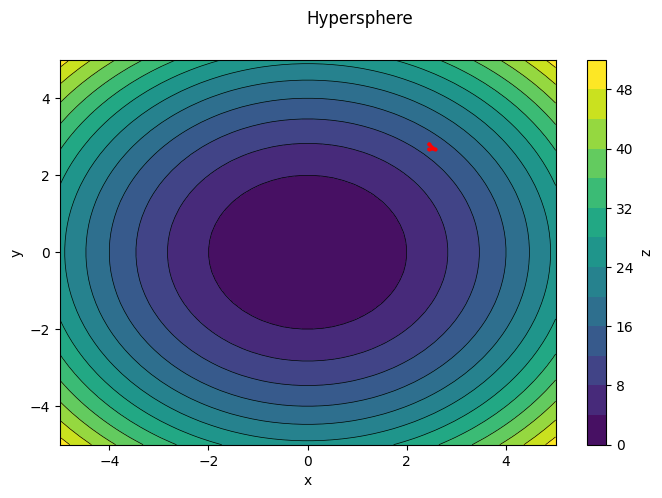

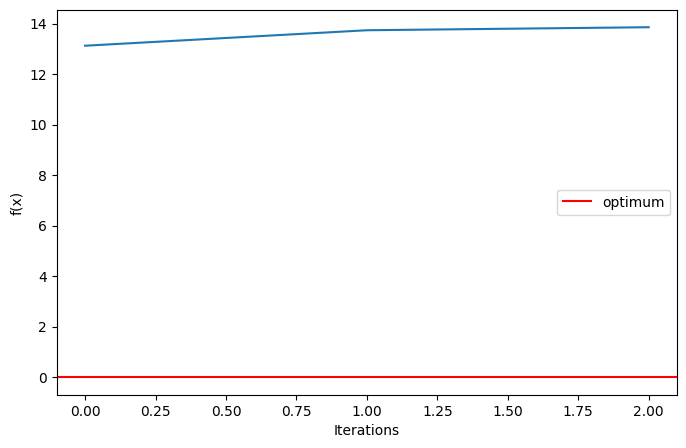


ITER N 1:
max_iter =  1

minimum value = 13.124848099695571


<Figure size 800x500 with 0 Axes>

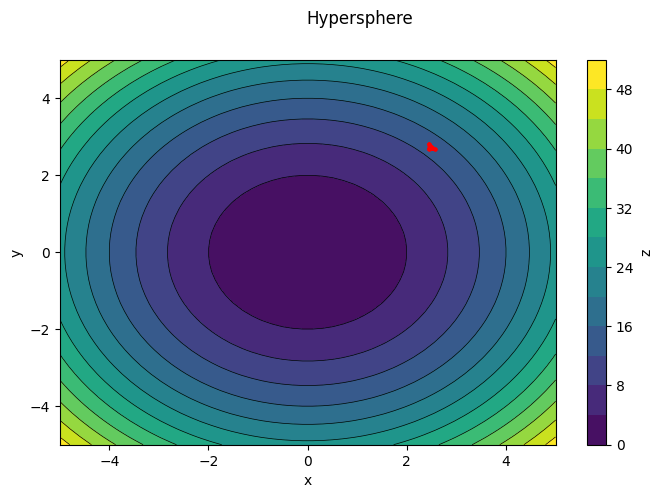

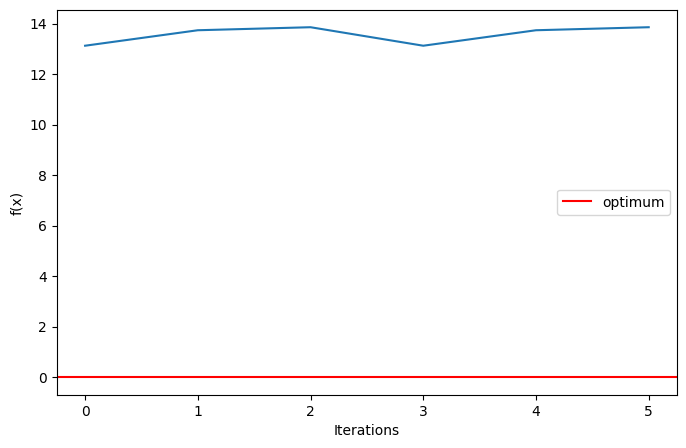


ITER N 2:
max_iter =  10

minimum value = 1.914019483491442


<Figure size 800x500 with 0 Axes>

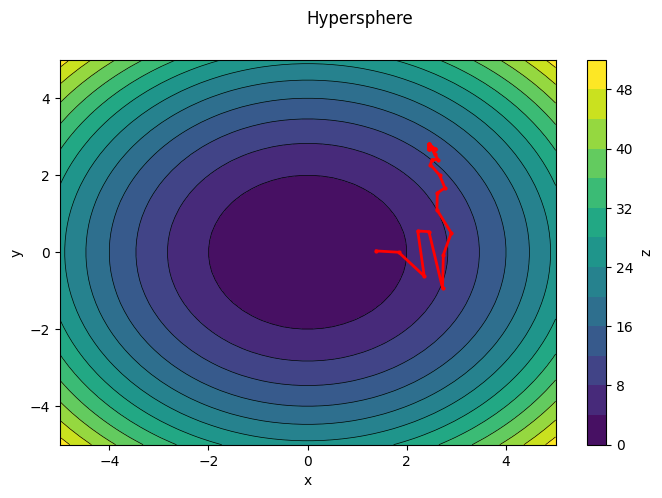

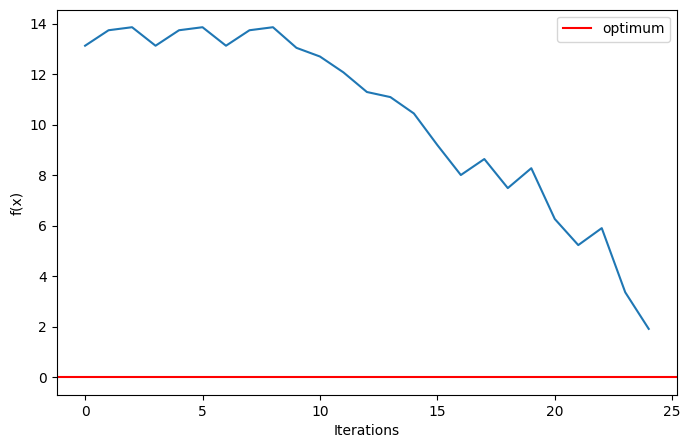


ITER N 3:
max_iter =  20

minimum value = 0.000892927750407021


<Figure size 800x500 with 0 Axes>

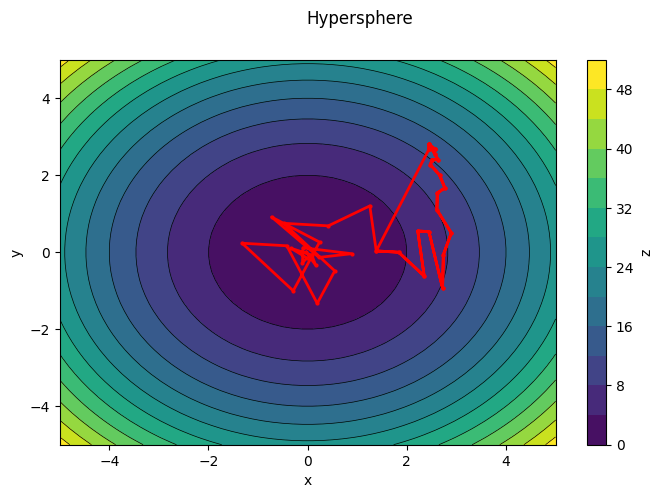

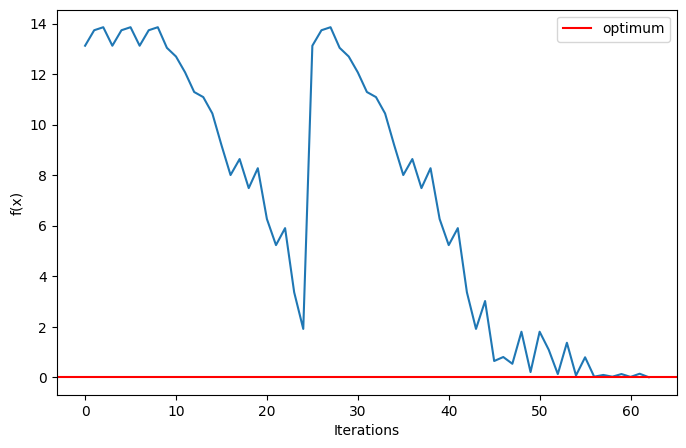


ITER N 4:
max_iter =  50

minimum value = 8.099902689433555e-12


<Figure size 800x500 with 0 Axes>

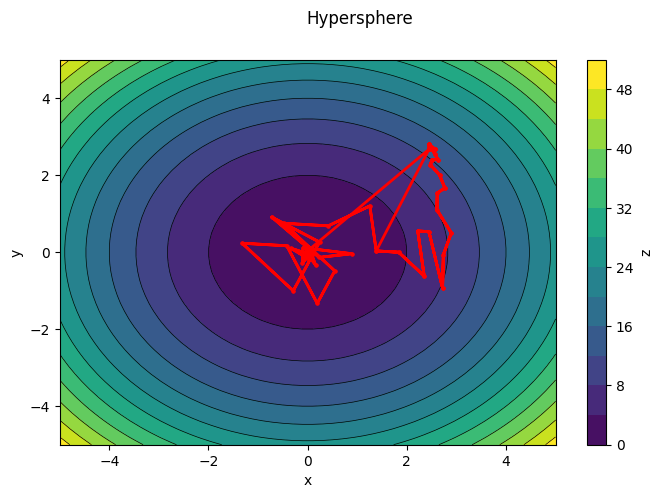

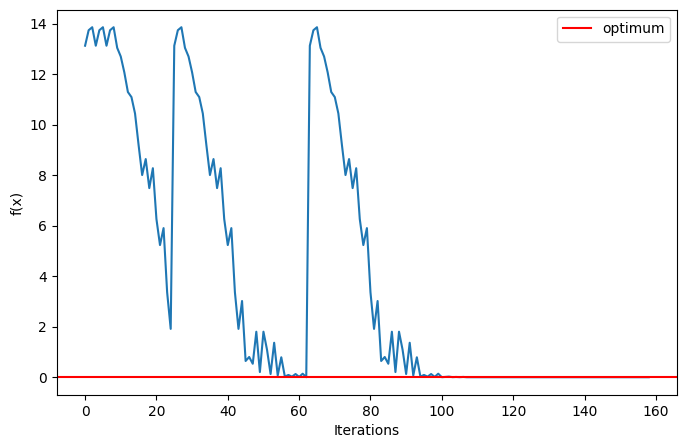

In [35]:
func = OptFun(bf.Hypersphere(2))  # TODO: try differenct benchmark functions and parameters
x_0 = [random.uniform(0,4) for _ in range(2)]   # TODO: try other suitable initial points
print('\npunto iniziale = ',x_0)
print('optimal value = ', func.minima()[0].score )

max_iter_list = [0.1, 1, 10, 20, 50]  # TODO: try other values
for i, max_iter in enumerate(max_iter_list):
    nelder_mead(func, x_0, max_iter)
    print(f'\nITER N {i}:\nmax_iter = ', max_iter)
    values = [func.f(v) for v in func.history]
    print('\nminimum value =', min(values))
    func.heatmap()
    func.plot()






## Final questions
- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?
- The choiche of the parameters is influenced by the function to optimize? And how the algorithm are influenced by the parameters?

In [36]:
# TODO: compare the different optimization algorithms